Time Series Analysis

In [33]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

# Data Preparation


Trigonometric Function

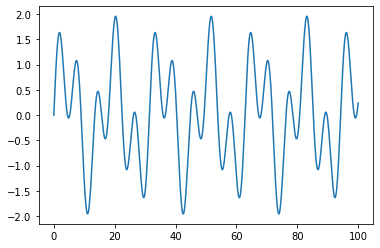

In [74]:
# ====== Generating Dataset ====== #
num_data = 2400
t = np.linspace(0.0, 100.0, num_data)
y = np.sin(t) + np.sin(0.4*t) 
e = np.random.normal(0, 0.1, num_data)
# y = y + e

plt.plot(t, y)

In [75]:
seq_len = 10
X = []
y_true = []
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    y_true.append(y[i+seq_len])
    
X = np.array(X)
print(X.shape)

y_true = np.array(y_true)
print(y_true.shape)

X = np.swapaxes(X,0,1) # 두 축을 바꿔줌
print(X.shape)
X = np.expand_dims(X, axis=2)
print(X.shape)

#Why do we need to expand_dims?
for x in X:
    print("Shape:", x.shape)
    break

(2390, 10)
(2390,)
(10, 2390)
(10, 2390, 1)
Shape: (2390, 1)


# Model Architecture

Idea : Process both new inputs and model output of previous input!

In [76]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size):
        super(RNN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size

        self.u = nn.Linear(self.input_dim, self.hid_dim, bias = False)
        self.w = nn.Linear(self.hid_dim, self.hid_dim, bias = False)
        self.v = nn.Linear(self.hid_dim, self.output_dim, bias = False)
        self.act = nn.Tanh()

        self.hidden = self.init_hidden() # initialize hidden

    def init_hidden(self, batch_size = None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(self.batch_size, self.hid_dim)
    
    def forward(self, x):
        h = self.act(self.u(x) + self.w(self.hidden))
        y = self.v(h)
        return y, h

# Experiment

### Train

In [85]:
import torch.optim as optim

model = RNN(1, 1, 10, 2390)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
epoch = 100
# print(model.hidden)

# ===== Train ===== #
loss_list = []
for i in range(epoch):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    model.hidden = model.init_hidden() # 꼭 RNN의 hidden state를 초기화 해줘야 함!

    # 한 epoch 당
    for x in X:
        x = torch.Tensor(x).float()
        y_true = torch.Tensor(y_true).float()
        # print(x.shape)
        y_pred, hidden = model(x)
        model.hidden = hidden
        # print(y_pred.shape)
        # print(model.hidden.shape)s
    loss = loss_fn(y_pred.view(-1), y_true.view(-1))
    loss.backward()
    optimizer.step()
    print(loss.item())
    loss_list.append(loss.item())

1.5794473886489868
1.5607885122299194
1.5423901081085205
1.524247407913208
1.5063555240631104
1.4887105226516724
1.4713081121444702
1.4541434049606323
1.4372128248214722
1.4205121994018555
1.404037356376648
1.3877849578857422
1.3717509508132935
1.3559314012527466
1.3403230905532837
1.3249222040176392
1.309725284576416
1.2947291135787964
1.2799304723739624
1.2653257846832275
1.250912070274353
1.2366864681243896
1.22264564037323
1.2087866067886353
1.1951065063476562
1.1816027164459229
1.1682722568511963
1.1551122665405273
1.1421202421188354
1.129293441772461
1.1166294813156128
1.1041256189346313
1.0917795896530151
1.0795890092849731
1.0675512552261353
1.0556641817092896
1.0439256429672241
1.0323331356048584
1.02088463306427
1.009577989578247
0.9984108209609985
0.9873815774917603
0.976487934589386
0.9657277464866638
0.9550992846488953
0.9446007013320923
0.9342299699783325
0.9239852428436279
0.9138649106025696
0.9038670063018799
0.8939898610115051
0.8842315673828125
0.8745908737182617
0.86

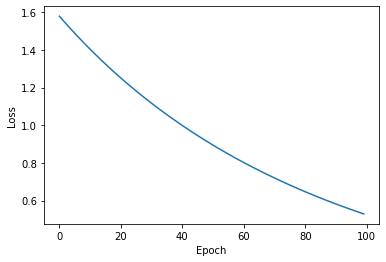

In [86]:
# ====== Plot Loss ====== #
plt.plot(loss_list)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Predict (Failed)

In [93]:
# ===== Predict ===== #
test_X = np.expand_dims(X[:, 0, :], 1)
# print(test_X.shape)

list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size = 1)

    for x in test_X:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    # print(y_pred.shape, x.shape) -> batch_size 가 다름

    list_y_pred.append(y_pred.mean().item())
    for i in range(2389):
        model.hidden = model.init_hidden(batch_size = 1)
        y_pred, hidden = model(y_pred)
        list_y_pred.append(y_pred.mean().item())
    
    print(list_y_pred)
    
# print(len(list_y_pred))

[0.19379203021526337, 0.05816616490483284, 0.01762452907860279, 0.005344864912331104, 0.001621026429347694, 0.0004916391335427761, 0.00014910881873220205, 4.522307790466584e-05, 1.3715669410885312e-05, 4.15981139667565e-06, 1.2616256981345941e-06, 3.8263726764853345e-07, 1.1604971206224945e-07, 3.519659941275677e-08, 1.0674744643779377e-08, 3.2375351288749243e-09, 9.819086654871967e-10, 2.978021995669877e-10, 9.032018188914748e-11, 2.739311728838789e-11, 8.308035683024517e-12, 2.519736806358419e-12, 7.642088459443308e-13, 2.317761867848267e-13, 7.029518297747145e-14, 2.1319753213820854e-14, 6.466048349014356e-15, 1.961082443218678e-15, 5.947747829798265e-16, 1.803887157191469e-16, 5.470991431143691e-17, 1.6592928759180965e-17, 5.032453109438394e-18, 1.526288127081434e-18, 4.629065042041956e-19, 1.403944960858756e-19, 4.258012369519011e-20, 1.2914086702639218e-20, 3.916702623819287e-21, 1.1878930548598233e-21, 3.60275148308039e-22, 1.0926748425399077e-22, 3.313963642066399e-23, 1.005089

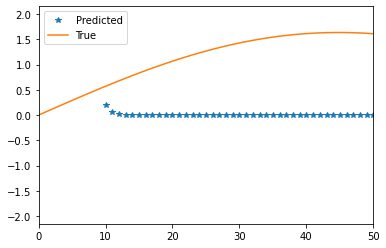

In [94]:
# ===== Plot Result ===== #
plt.plot(list(range(10,2400)), list_y_pred, '*', label = 'Predicted')
plt.plot(y, label = 'True')

plt.xlim(0, 50)

plt.legend()
plt.show()

-> Gradient Vanishing Problem !